<a href="https://colab.research.google.com/github/vladislavdarii/Ship-classification-using-Machine-Learning-techniques/blob/main/04_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1.0 Imports and drive mount

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import librosa
import scipy.signal
import pandas as pd
from numpy.matrixlib.defmatrix import matrix
from sklearn import svm


#Writing and loading variables
import pickle

#Decission tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title 1.1 Function: Class Accuracy Plot and Metrics

def plot_class_acc(y_val, y_pred, strr):

  # Initialize the lists for correctly and incorrectly predicted values
  correct_preds = [0, 0, 0, 0]
  incorrect_preds = [0, 0, 0, 0]

  # Loop over the samples in y_test and y_pred
  for i in range(len(y_val)):
      if y_val[i] == y_pred[i]:
          correct_preds[y_val[i]] += 1
      else:
          incorrect_preds[y_val[i]] += 1

  # Set the colors for the bars
  bar_colors = ['#009965', '#a52a2b']

  # Create the bar chart with two parts for each bar
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.bar(range(len(correct_preds)), correct_preds, color=bar_colors[0], label='Correct Predictions')
  ax.bar(range(len(incorrect_preds)), incorrect_preds, bottom=correct_preds, color=bar_colors[1], label='Incorrect Predictions')

  for i, (corr, incorr) in enumerate(zip(correct_preds, incorrect_preds)):
      ax.text(i, corr/2, str(corr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
      ax.text(i, corr + incorr/2, str(incorr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

  # Set the x-ticks and labels
  ax.set_xticks(range(len(correct_preds)))
  ax.set_xticklabels(['Class A', 'Class B', 'Class C', 'Class D'])

  # Set the labels and title
  ax.set_xlabel('Boat Type')
  ax.set_ylabel('Count')
  ax.set_title(strr)

  # Add the legend
  ax.legend()

  # Show the plot
  plt.show()

  # #Metric calculation
  # Create confusion matrix
  cm = confusion_matrix(y_val, y_pred)

  # Convert the confusion matrix to a pandas DataFrame
  confusion_matrix_df = pd.DataFrame(cm, columns=['Class A', 'Class B', 'Class C', 'Class D'])

  # Calculate metrics
  metrics_df = calculate_metrics(confusion_matrix_df.values)

  # Print the results
  print("Confusion Matrix:")
  print(confusion_matrix_df)
  print("\nMetrics:")
  print(metrics_df)

  return metrics_df, confusion_matrix_df

def calculate_metrics(confusion_matrix):
    tp = np.diagonal(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - tp
    fn = confusion_matrix.sum(axis=1) - tp
    tn = confusion_matrix.sum() - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

    metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    }
    #Get rid of NaN values
    metrics_dict = pd.DataFrame(metrics_dict)
    metrics_dict.fillna(0, inplace=True)
    return metrics_dict

#@title 5.1 Get final metrics

def metrics_avg_var(metrics):
 row = [0,1,2,3]
 Precision = []
 Recall = []
 F1_Score = []
 Accuracy = []
 Precision_var = []
 Recall_var = []
 F1_Score_var = []
 Accuracy_var = []

 for a in row:
  Precision.append(np.average([df.loc[a, 'Precision'] for df in metrics]))
  Recall.append(np.average([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score.append(np.average([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy.append(np.average([df.loc[a, 'Accuracy'] for df in metrics]))
  Precision_var.append(np.std([df.loc[a, 'Precision'] for df in metrics]))
  Recall_var.append(np.std([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score_var.append(np.std([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy_var.append(np.std([df.loc[a, 'Accuracy'] for df in metrics]))

 metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': Precision,
        'P_std' : Precision_var,
        'Recall': Recall,
        'R_std' : Recall_var,
        'F1 Score': F1_Score,
        'F1_std': F1_Score_var,
        'Accuracy': Accuracy,
        'Acc_std': Accuracy_var
    }


 return pd.DataFrame(metrics_dict)

In [ ]:
#@title 2.1 Data Load

def dataload(datax):
  # Define the directory where the file is saved
  directory = "./drive/MyDrive/TFG/Data/"

  # Load the variables from the file
  with open(os.path.join(directory, datax), "rb") as f:
      X_train, X_test, X_val, y_train, y_test, y_val = pickle.load(f)

  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  return X_train, X_test, X_val, y_train, y_test, y_val

def save_model(model,modeltype,n):

  model_filename = "SVM_" + str(modeltype) +  "_" + str(n) + ".pkl"

  # Define the directory where you want to save the file
  directory = "./drive/MyDrive/TFG/Models/SVM/"  #change to /DTs to actually overwrite stored models
  if 1 == 1:
    # Save the variables to a file
    with open(os.path.join(directory, model_filename), "wb") as f:
        pickle.dump((model), f)
    return

In [ ]:
#@title 3.1 Feature extraction: PSD

def get_psd():

  psd_train = []
  psd_test = []
  psd_val = []

  # Calculate the zero-crossing rate for X_train
  for audio in X_train:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024) # best so far 2*1024
    psd_train.append(S/max(S))

  psd_train = np.array(psd_train)

  # Calculate the zero-crossing rate for X_val
  for audio in X_val:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_val.append(S/max(S))

  psd_val = np.array(psd_val)

  # Calculate the zero-crossing rate for X_test
  for audio in X_test:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_test.append(S/max(S))

  psd_test = np.array(psd_test)
  return psd_train, psd_val, psd_test

In [ ]:
#@title 3.2 Feature extraction: MFCC
def get_mfcc():
# Define the frame length and hop length in samples
  frame_length = 2000
  hop_length =  1000

  # Define the number of MFCCs to extract
  num_mfcc = 15

  # Define the sampling rate of the audio signals
  sr = 52734

  mfcc_train = []
  mfcc_val = []
  mfcc_test = []

  # Extract MFCC features for the training set
  for audio in X_train:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_train.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_train = np.array(mfcc_train)


  # Extract MFCC features for the validation set
  for audio in X_val:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_val.append(mfcc.flatten())


  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_val = np.array(mfcc_val)

  # Extract MFCC features for the test set
  for audio in X_test:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length )#,fmin = 25, fmax = 7500)
      mfcc_test.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_test = np.array(mfcc_test)
  return  mfcc_train, mfcc_val, mfcc_test

In [ ]:
#@title 4.1 SVM Raw Data

def get_SVM_raw(n):
  SVM_raw = svm.SVC(kernel='rbf',C=100)
  SVM_raw.fit(X_train, y_train)
  #y_pred = SVM.predict(X_val)
  #y_pred = SVM.predict(X_train)
  y_pred = SVM_raw.predict(X_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test data")
  save_model(SVM_raw,"raw",n)
  return metrics, matrix

In [ ]:
#@title 4.2 SVM MFCC

def get_SVM_mfcc(n):
  SVM_mfcc = svm.SVC(kernel='rbf', C = 200000, verbose = True, gamma =  5e-08)
  SVM_mfcc.fit(mfcc_train, y_train)
  #y_pred = SVM.predict(X_val)
  #y_pred = SVM.predict(X_train)
  y_pred = SVM_mfcc.predict(mfcc_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test data")
  save_model(SVM_mfcc,"mfcc",n)
  return metrics, matrix

In [ ]:
#@title 4.3 SVM PSD

def get_SVM_psd(n):
  SVM_psd = svm.SVC(kernel='rbf', C = 1, verbose = True)
  SVM_psd.fit(psd_train, y_train)
  #y_pred = SVM.predict(X_val)
  #y_pred = SVM.predict(X_train)
  y_pred = SVM_psd.predict(psd_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test data")
  save_model(SVM_psd,"psd",n)
  return metrics, matrix

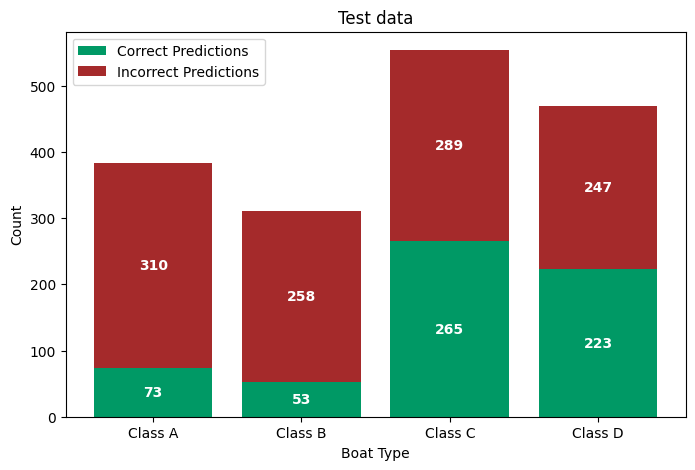

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       73       39      147      124
1       85       53      120       53
2       72       65      265      152
3       63       57      127      223

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.249147  0.190601  0.215976  0.357392
1  Class 1   0.247664  0.170418  0.201905  0.357392
2  Class 2   0.402124  0.478339  0.436933  0.357392
3  Class 3   0.403986  0.474468  0.436399  0.357392
[LibSVM]

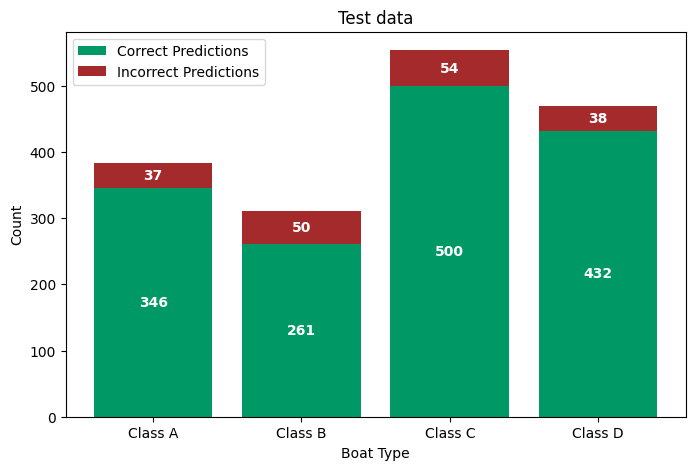

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      346       11        9       17
1       18      261       26        6
2       21       24      500        9
3       18        8       12      432

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.858561  0.903394  0.880407  0.895809
1  Class 1   0.858553  0.839228  0.848780  0.895809
2  Class 2   0.914077  0.902527  0.908265  0.895809
3  Class 3   0.931034  0.919149  0.925054  0.895809
[LibSVM]

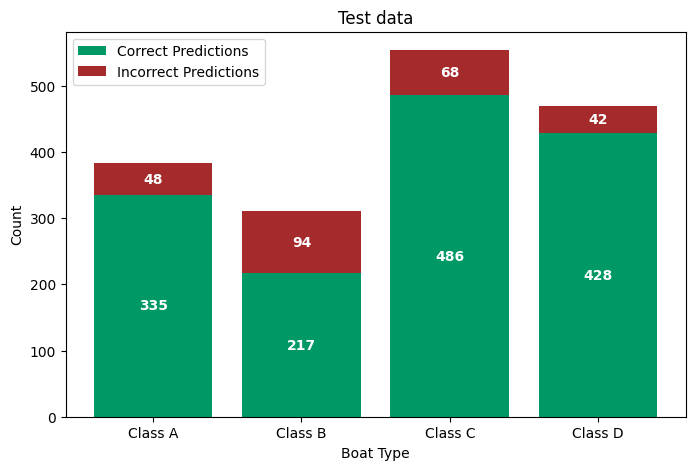

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      335        2       20       26
1       14      217       67       13
2       25       12      486       31
3       18        2       22      428

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.854592  0.874674  0.864516  0.853318
1  Class 1   0.931330  0.697749  0.797794  0.853318
2  Class 2   0.816807  0.877256  0.845953  0.853318
3  Class 3   0.859438  0.910638  0.884298  0.853318


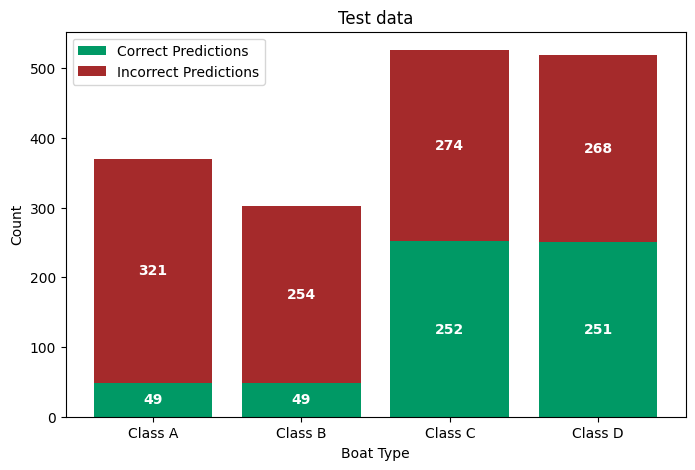

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       49       29      167      125
1       46       49      143       65
2       73       69      252      132
3       68       77      123      251

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.207627  0.132432  0.161716  0.349825
1  Class 1   0.218750  0.161716  0.185958  0.349825
2  Class 2   0.367883  0.479087  0.416185  0.349825
3  Class 3   0.438045  0.483622  0.459707  0.349825
[LibSVM]

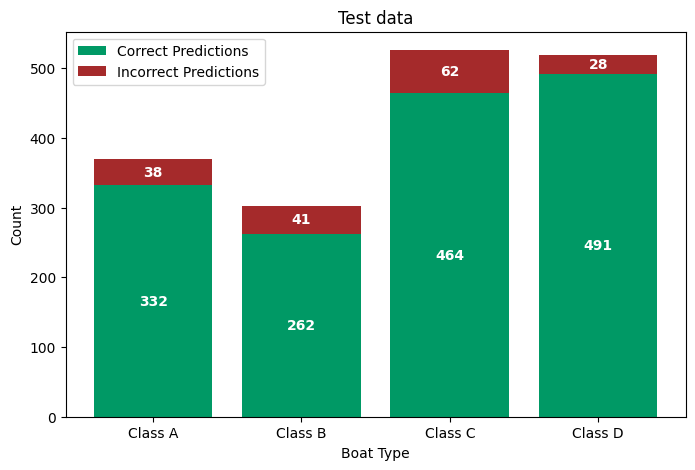

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      332       10       16       12
1       17      262       17        7
2       23       33      464        6
3       21        5        2      491

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.844784  0.897297  0.870249   0.90163
1  Class 1   0.845161  0.864686  0.854812   0.90163
2  Class 2   0.929860  0.882129  0.905366   0.90163
3  Class 3   0.951550  0.946050  0.948792   0.90163
[LibSVM]

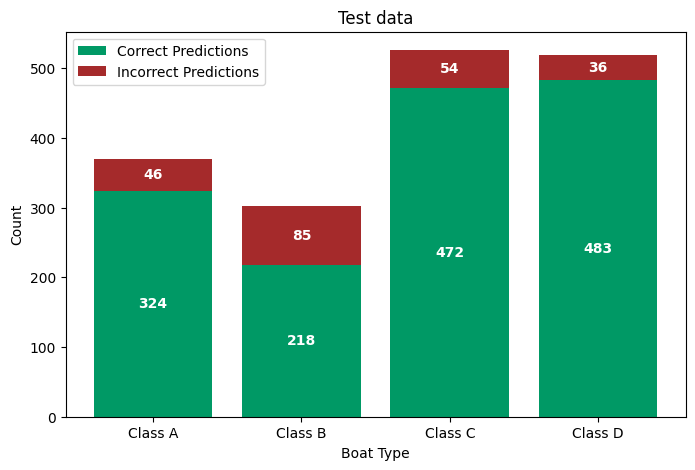

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      324        4       23       19
1       16      218       60        9
2       25        8      472       21
3       12        2       22      483

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.859416  0.875676  0.867470  0.871362
1  Class 1   0.939655  0.719472  0.814953  0.871362
2  Class 2   0.818024  0.897338  0.855848  0.871362
3  Class 3   0.907895  0.930636  0.919125  0.871362


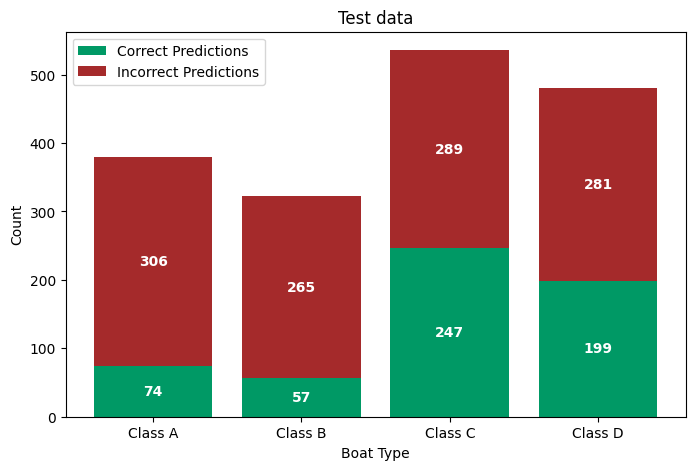

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       74       49      138      119
1       58       57      151       56
2       88       72      247      129
3       75       70      136      199

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.250847  0.194737  0.219259  0.335856
1  Class 1   0.229839  0.177019  0.200000  0.335856
2  Class 2   0.367560  0.460821  0.408940  0.335856
3  Class 3   0.395626  0.414583  0.404883  0.335856
[LibSVM]

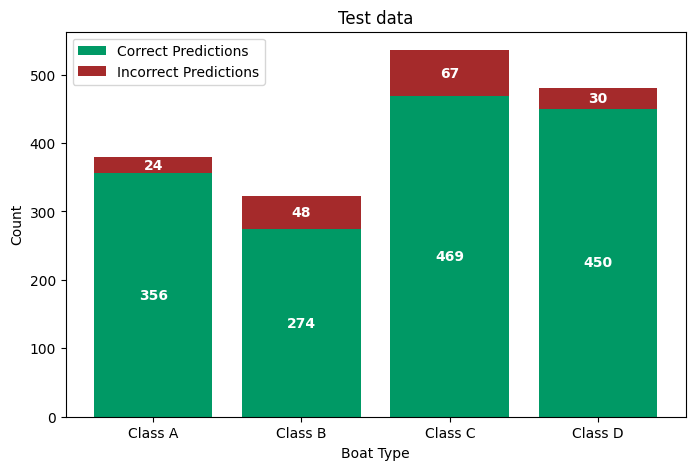

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      356       10       10        4
1       18      274       20       10
2       26       29      469       12
3       16        8        6      450

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.855769  0.936842  0.894472   0.90163
1  Class 1   0.853583  0.850932  0.852255   0.90163
2  Class 2   0.928713  0.875000  0.901057   0.90163
3  Class 3   0.945378  0.937500  0.941423   0.90163
[LibSVM]

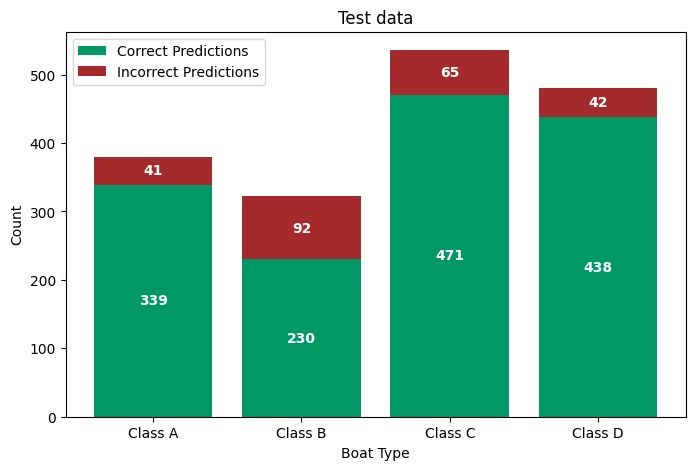

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      339        3       19       19
1       12      230       63       17
2       31        6      471       28
3       18        2       22      438

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.847500  0.892105  0.869231  0.860303
1  Class 1   0.954357  0.714286  0.817052  0.860303
2  Class 2   0.819130  0.878731  0.847885  0.860303
3  Class 3   0.872510  0.912500  0.892057  0.860303


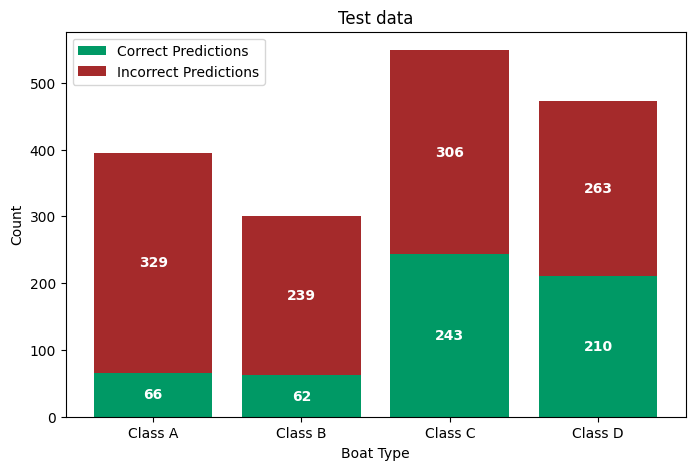

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       66       49      151      129
1       52       62      119       68
2       90       80      243      136
3       76       61      126      210

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.232394  0.167089  0.194404  0.338184
1  Class 1   0.246032  0.205980  0.224231  0.338184
2  Class 2   0.380282  0.442623  0.409091  0.338184
3  Class 3   0.386740  0.443975  0.413386  0.338184
[LibSVM]

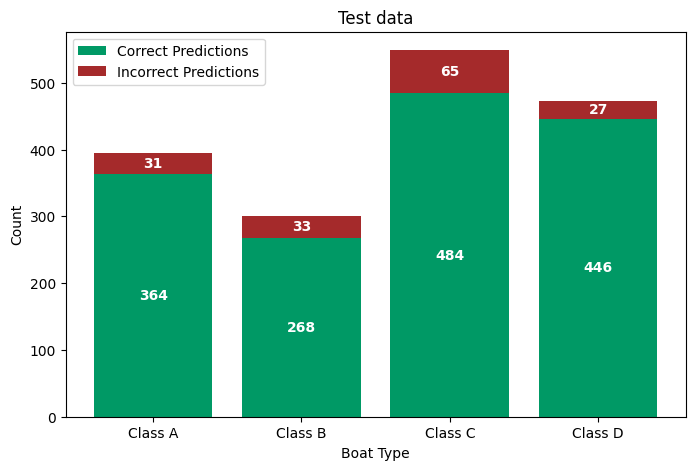

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      364       10        9       12
1        6      268       24        3
2       23       23      484       19
3       16        6        5      446

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.889976  0.921519  0.905473  0.909197
1  Class 1   0.872964  0.890365  0.881579  0.909197
2  Class 2   0.927203  0.881603  0.903828  0.909197
3  Class 3   0.929167  0.942918  0.935992  0.909197
[LibSVM]

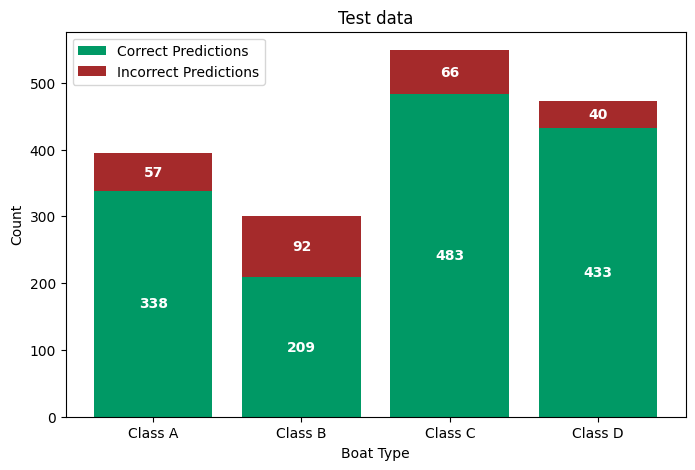

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      338        3       28       26
1        9      209       74        9
2       24       14      483       28
3       12        2       26      433

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.882507  0.855696  0.868895  0.851572
1  Class 1   0.916667  0.694352  0.790170  0.851572
2  Class 2   0.790507  0.879781  0.832759  0.851572
3  Class 3   0.872984  0.915433  0.893705  0.851572


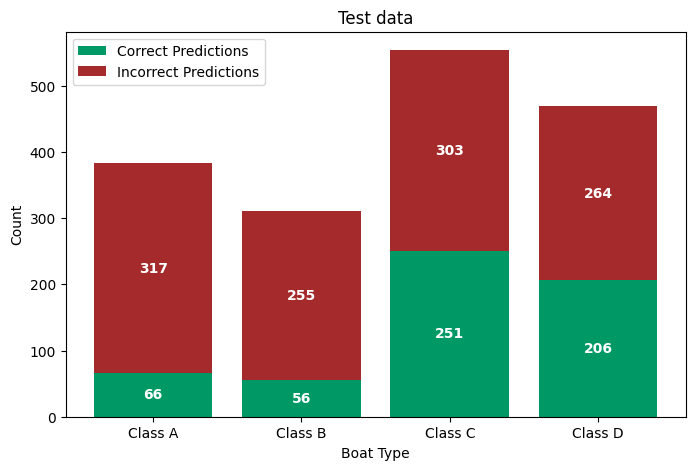

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       66       57      141      119
1       63       56      138       54
2       83       80      251      140
3       66       82      116      206

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.237410  0.172324  0.199697   0.33702
1  Class 1   0.203636  0.180064  0.191126   0.33702
2  Class 2   0.388545  0.453069  0.418333   0.33702
3  Class 3   0.396917  0.438298  0.416582   0.33702
[LibSVM]

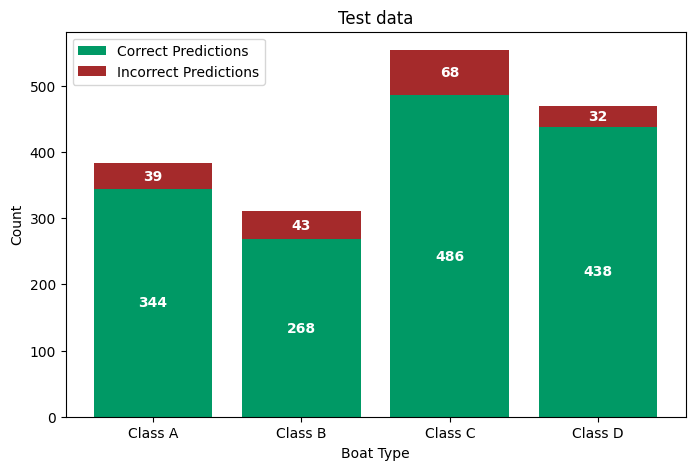

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      344       12       10       17
1       18      268       17        8
2       33       26      486        9
3       22        3        7      438

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.824940  0.898172  0.860000  0.894063
1  Class 1   0.867314  0.861736  0.864516  0.894063
2  Class 2   0.934615  0.877256  0.905028  0.894063
3  Class 3   0.927966  0.931915  0.929936  0.894063
[LibSVM]

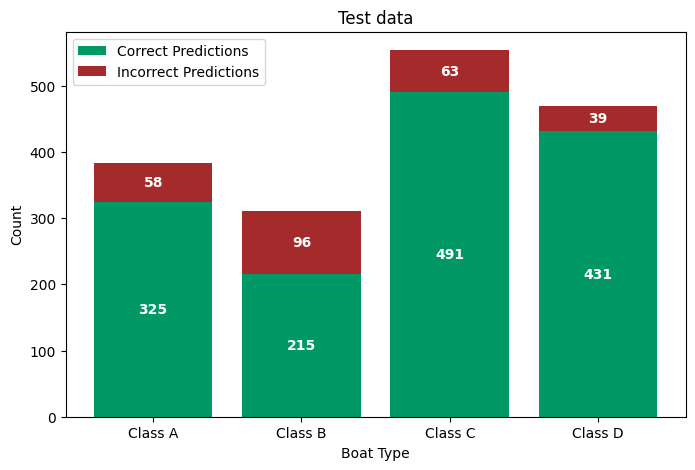

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      325        8       33       17
1       12      215       75        9
2       27       15      491       21
3       16        3       20      431

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.855263  0.848564  0.851900   0.85099
1  Class 1   0.892116  0.691318  0.778986   0.85099
2  Class 2   0.793215  0.886282  0.837170   0.85099
3  Class 3   0.901674  0.917021  0.909283   0.85099


In [ ]:
#@title 5.2 Test results extraction

# Metric activator
raw = 1
mfcc = 1
psd = 1


metrics_raw1 = []
metrics_mfcc1 = []
metrics_psd1 = []
matrix_raw = []
matrix_mfcc = []
matrix_psd = []
val = 1
data = ['data1.pkl','data2.pkl','data3.pkl','data4.pkl','data5.pkl']

for d in data:
  X_train, X_test, X_val, y_train, y_test, y_val = dataload(d)

  if raw == 1:
  # Get raw data
    metrics, matrix = get_SVM_raw(val)
    metrics_raw1.append(metrics)
    matrix_raw.append(matrix)
  if mfcc == 1:
  # Get mfcc data
    mfcc_train, mfcc_val, mfcc_test = get_mfcc()
    metrics1, matrix1 = get_SVM_mfcc(val)
    metrics_mfcc1.append(metrics1)
    matrix_mfcc.append(matrix1)
 # Get psd data
  if psd == 1:
    psd_train, psd_val, psd_test = get_psd()
    metrics2, matrix2 = get_SVM_psd(val)
    metrics_psd1.append(metrics2)
    matrix_psd.append(matrix2)
  val = val + 1

pd.options.display.float_format = '{:.3f}'.format

if raw == 1:
  metrics_raw = metrics_avg_var(metrics_raw1)
if mfcc == 1:
  metrics_mfcc = metrics_avg_var(metrics_mfcc1)
if psd == 1:
  metrics_psd = metrics_avg_var(metrics_psd1)


In [ ]:
# Get the value of gamma used in the model
gamma_scale_value = 1 / (90 * mfcc_train.var())

print("Computed gamma scale value:", gamma_scale_value)

Computed gamma scale value: 5.179841075623264e-08


In [ ]:
#@title Print Table

def get_number(row,col, metrics):
 cols = ['Precision','Recall','F1 Score']
 a = metrics.at[row,col]
 highest = 0
 if col in cols:
  for value in metrics[col]:
    if value > a:
      highest = 1
  if highest == 0:
    a = "\highest{" + str(a) + "}"
 return str(a)

def print_table(metrics):

#metrics table formatting


  columns_to_format = ['Precision',
                        'Recall',
                        'F1 Score',
                          'Accuracy']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)
  columns_to_format = ['P_std','R_std','F1_std','Acc_std']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)


  print(
  "Class A                           & " + get_number(0,'Precision',metrics) + "                               & (" + get_number(0,'P_std',metrics) + ")     & " + get_number(0,'Recall',metrics) + "                         & (" + get_number(0,'R_std',metrics) + ")         & " + get_number(0,'F1 Score',metrics) + "                  & (" + get_number(0,'F1_std',metrics) + ")                   \\\\"
  " \\rowcolor[HTML]{EFEFEF} Class B                           & " + get_number(1,'Precision',metrics) + "                               & (" + get_number(1,'P_std',metrics) + ")      & " + get_number(1,'Recall',metrics) + "                         & (" + get_number(1,'R_std',metrics) + ")         & " + get_number(1,'F1 Score',metrics) + "                  & (" + get_number(1,'F1_std',metrics) + ")                  \\\\"
  "Class C                           & " + get_number(2,'Precision',metrics) + "                               & (" + get_number(2,'P_std',metrics) + ")      & " + get_number(2,'Recall',metrics) + "                        & (" + get_number(2,'R_std',metrics) + ")         & " + get_number(2,'F1 Score',metrics) + "                  & (" + get_number(2,'F1_std',metrics) + ")                  \\\\")
  print("\\rowcolor[HTML]{EFEFEF} "
  "Class D                           & " + get_number(3,'Precision',metrics) + "                              & (" + get_number(3,'P_std',metrics) + ")      & " + get_number(3,'Recall',metrics) + "                         & (" + get_number(3,'R_std',metrics) + ")         & " + get_number(3,'F1 Score',metrics) + "                  & (" + get_number(3,'F1_std',metrics) + ")                 \\\\ \midrule"
  "\\multicolumn{1}{c}{\\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \\textbf{" + get_number(3,'Accuracy',metrics) + "}         & \\textbf{(" + get_number(2,'Acc_std',metrics) + ")}  ")
  return


print_table(metrics_psd
            )

Class A                           & 0.86                               & (0.012)     & 0.869                         & (0.016)         & 0.864                  & (0.006)                   \\ \rowcolor[HTML]{EFEFEF} Class B                           & \highest{0.927}                               & (0.021)      & 0.703                         & (0.011)         & 0.8                  & (0.015)                  \\Class C                           & 0.808                               & (0.013)      & 0.884                        & (0.007)         & 0.844                  & (0.008)                  \\
\rowcolor[HTML]{EFEFEF} Class D                           & 0.883                              & (0.019)      & \highest{0.917}                         & (0.007)         & \highest{0.9}                  & (0.013)                 \\ \midrule\multicolumn{1}{c}{\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \textb

In [ ]:
#@title Print Matrix

def get_max_matrix(matrix):
  a = 0
  pos = 5
  tp_max = 0
  for m in matrix:
    tp = sum(np.diagonal(m))
    if tp_max < tp:
      tp_max = tp
      pos = a
    a = a+1
  return pos

def get_matrix(matrix):
  matrix = matrix[get_max_matrix(matrix)]
  col = ['Class A','Class B','Class C','Class D']
  for i in list(range(4)):
    for j in list(range(4)):
      print(j,i,matrix.at[i,col[j]])

print("x y C")
get_matrix(matrix_psd)


x y C
0 0 324
1 0 4
2 0 23
3 0 19
0 1 16
1 1 218
2 1 60
3 1 9
0 2 25
1 2 8
2 2 472
3 2 21
0 3 12
1 3 2
2 3 22
3 3 483


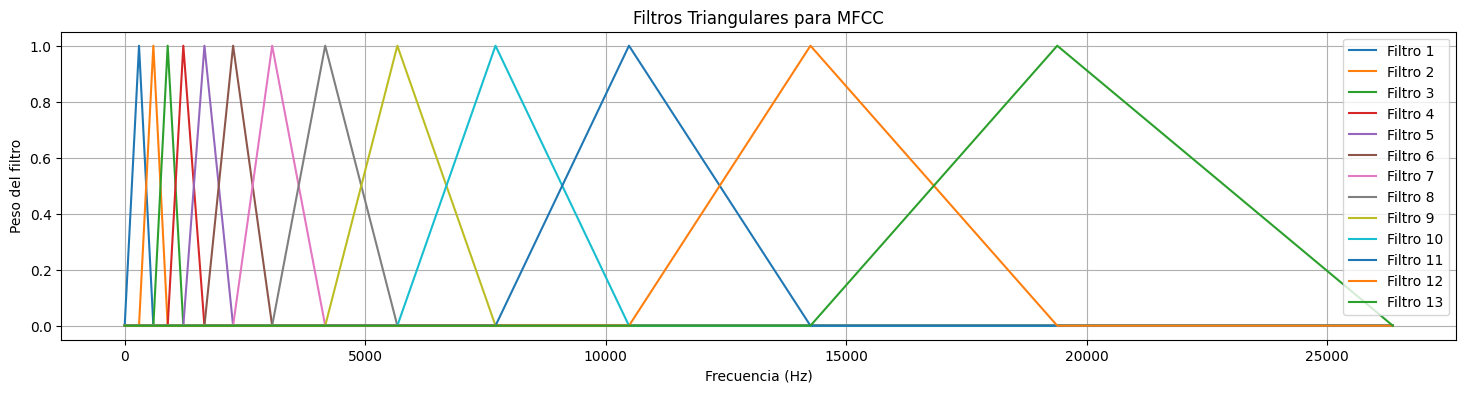

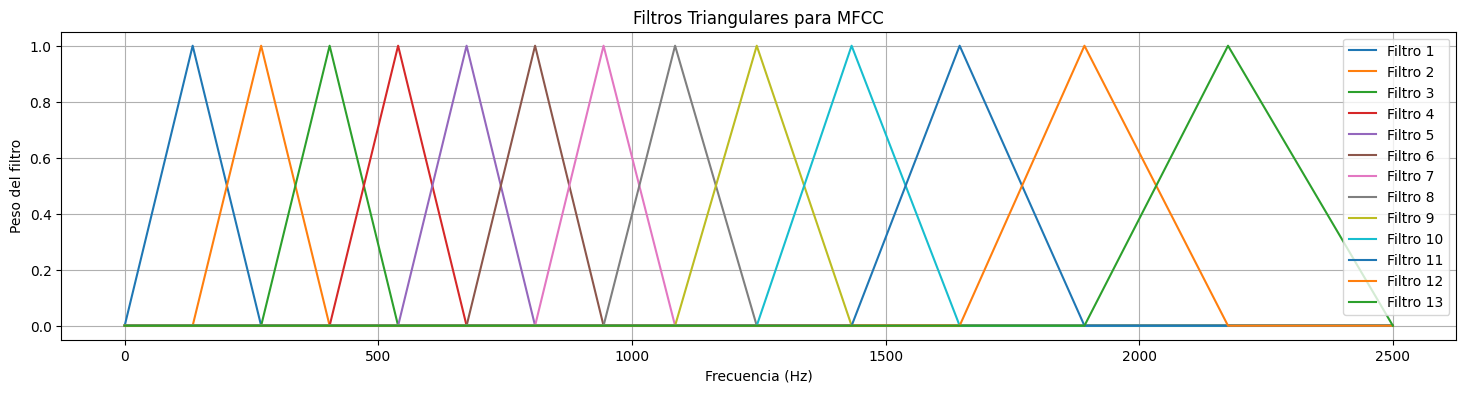

In [ ]:
#@title 3.3 MFCCs 52KHz vs 5KHz representation

import librosa
import numpy as np
import matplotlib.pyplot as plt

# Obtener la frecuencia de la primera banda de MFCC
mel_frequencies = librosa.mel_frequencies(n_mels=15, fmin=0, fmax=52734/2)
print(mel_frequencies)

#MFCCs para 52kHz
mfcc_frequencies_hz = np.array([  0,   298, 596,   894, 1219, 1658, 2254, 3066,  4169,  5669,  7710, 10485, 14258, 19389, 26367 ])

# Convertir las frecuencias de Hz a Mel
mfcc_frequencies_mel = librosa.hz_to_mel(mfcc_frequencies_hz)

# Calcular los bordes izquierdo, central y derecho de cada filtro triangular
filter_left = mfcc_frequencies_mel[:-2]
filter_center = mfcc_frequencies_mel[1:-1]
filter_right = mfcc_frequencies_mel[2:]

# Crear los filtros triangulares
filters = np.zeros((len(mfcc_frequencies_mel) - 2, len(mfcc_frequencies_hz)))
for i in range(len(filter_center)):
    filters[i] = np.maximum(0, np.minimum((mfcc_frequencies_mel - filter_left[i]) / (filter_center[i] - filter_left[i]),
                                          (filter_right[i] - mfcc_frequencies_mel) / (filter_right[i] - filter_center[i])))

# Visualizar los filtros triangulares
plt.figure(figsize=(18,4))
for i in range(len(filter_center)):
    plt.plot(mfcc_frequencies_hz, filters[i], label=f'Filtro {i + 1}')

plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Peso del filtro')
plt.title('Filtros Triangulares para MFCC')
plt.legend()
plt.grid(True)
plt.show()

# MFCC para 5Khz
mfcc_frequencies_hz = np.array([   0,  134,  269,  404, 539,  674,  809,  944, 1085, 1246, 1433, 1646, 1892, 2175, 2500 ])

# Convertir las frecuencias de Hz a Mel
mfcc_frequencies_mel = librosa.hz_to_mel(mfcc_frequencies_hz)

# Calcular los bordes izquierdo, central y derecho de cada filtro triangular
filter_left = mfcc_frequencies_mel[:-2]
filter_center = mfcc_frequencies_mel[1:-1]
filter_right = mfcc_frequencies_mel[2:]

# Crear los filtros triangulares
filters = np.zeros((len(mfcc_frequencies_mel) - 2, len(mfcc_frequencies_hz)))
for i in range(len(filter_center)):
    filters[i] = np.maximum(0, np.minimum((mfcc_frequencies_mel - filter_left[i]) / (filter_center[i] - filter_left[i]),
                                          (filter_right[i] - mfcc_frequencies_mel) / (filter_right[i] - filter_center[i])))

# Visualizar los filtros triangulares
plt.figure(figsize=(18, 4))
for i in range(len(filter_center)):
    plt.plot(mfcc_frequencies_hz, filters[i], label=f'Filtro {i + 1}')

plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Peso del filtro')
plt.title('Filtros Triangulares para MFCC')
plt.legend()
plt.grid(True)
plt.show()